In [1]:
import pandas                  as     pd
import missingno               as     msno
import seaborn                 as     sns
import matplotlib.pyplot       as     plt
import statsmodels.api         as     sm
import scipy.stats             as     stats
import numpy                   as     np
from   sklearn.linear_model    import LinearRegression
from   sklearn.metrics         import mean_squared_error, r2_score
from   sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

# Data Wrangling

In [2]:
# Import dataset into Pandas DataFrame
df_raw    = pd.read_csv("../dat/ship_data.csv")
n_records = df_raw.shape[0]

# Check column names and data types
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16248 entries, 0 to 16247
Data columns (total 26 columns):
Time                                                          16248 non-null int64
Main Engine Fuel Consumption (MT/day)                         16085 non-null float64
Main Engine Using HFO (bool)                                  16085 non-null float64
Main Engine Using MGO (bool)                                  16085 non-null float64
Draft Forward (meters)                                        16085 non-null float64
Draft Aft (meters)                                            16085 non-null float64
Draft Mid-1 (meters)                                          16085 non-null float64
Draft Mid-2 (meters)                                          16085 non-null float64
Shaft Speed (RPM)                                             16085 non-null float64
Shaft Torque (kNm)                                            16085 non-null float64
Shaft Power (kW)                           

### Missing Records

Time                                                            0
Main Engine Fuel Consumption (MT/day)                         163
Main Engine Using HFO (bool)                                  163
Main Engine Using MGO (bool)                                  163
Draft Forward (meters)                                        163
Draft Aft (meters)                                            163
Draft Mid-1 (meters)                                          163
Draft Mid-2 (meters)                                          163
Shaft Speed (RPM)                                             163
Shaft Torque (kNm)                                            163
Shaft Power (kW)                                              163
Speed Over Ground (knots)                                     163
Speed Through Water (knots)                                   163
Heading (degrees)                                               8
Rudder Angle (degrees)                                        163
Weather Se

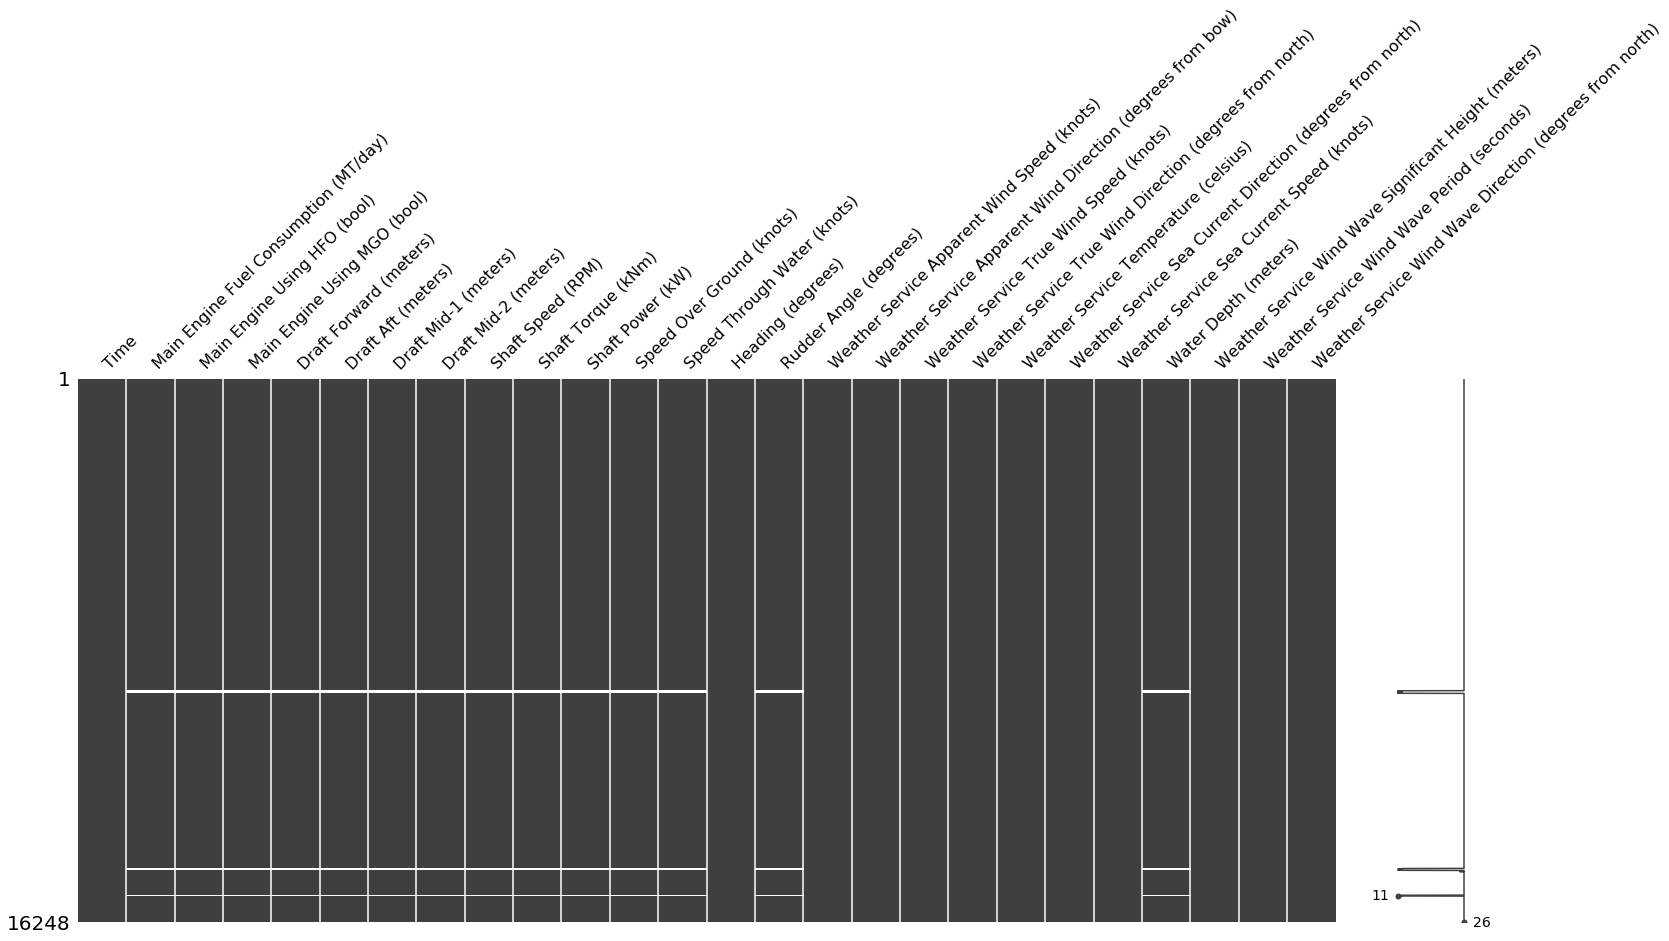

In [3]:
# Check missing values
print(df_raw.isnull().sum())
msno.matrix(df_raw)

Percentage of missing records:    1.0093549975381588
Percentage of remaining records:  98.99064500246185


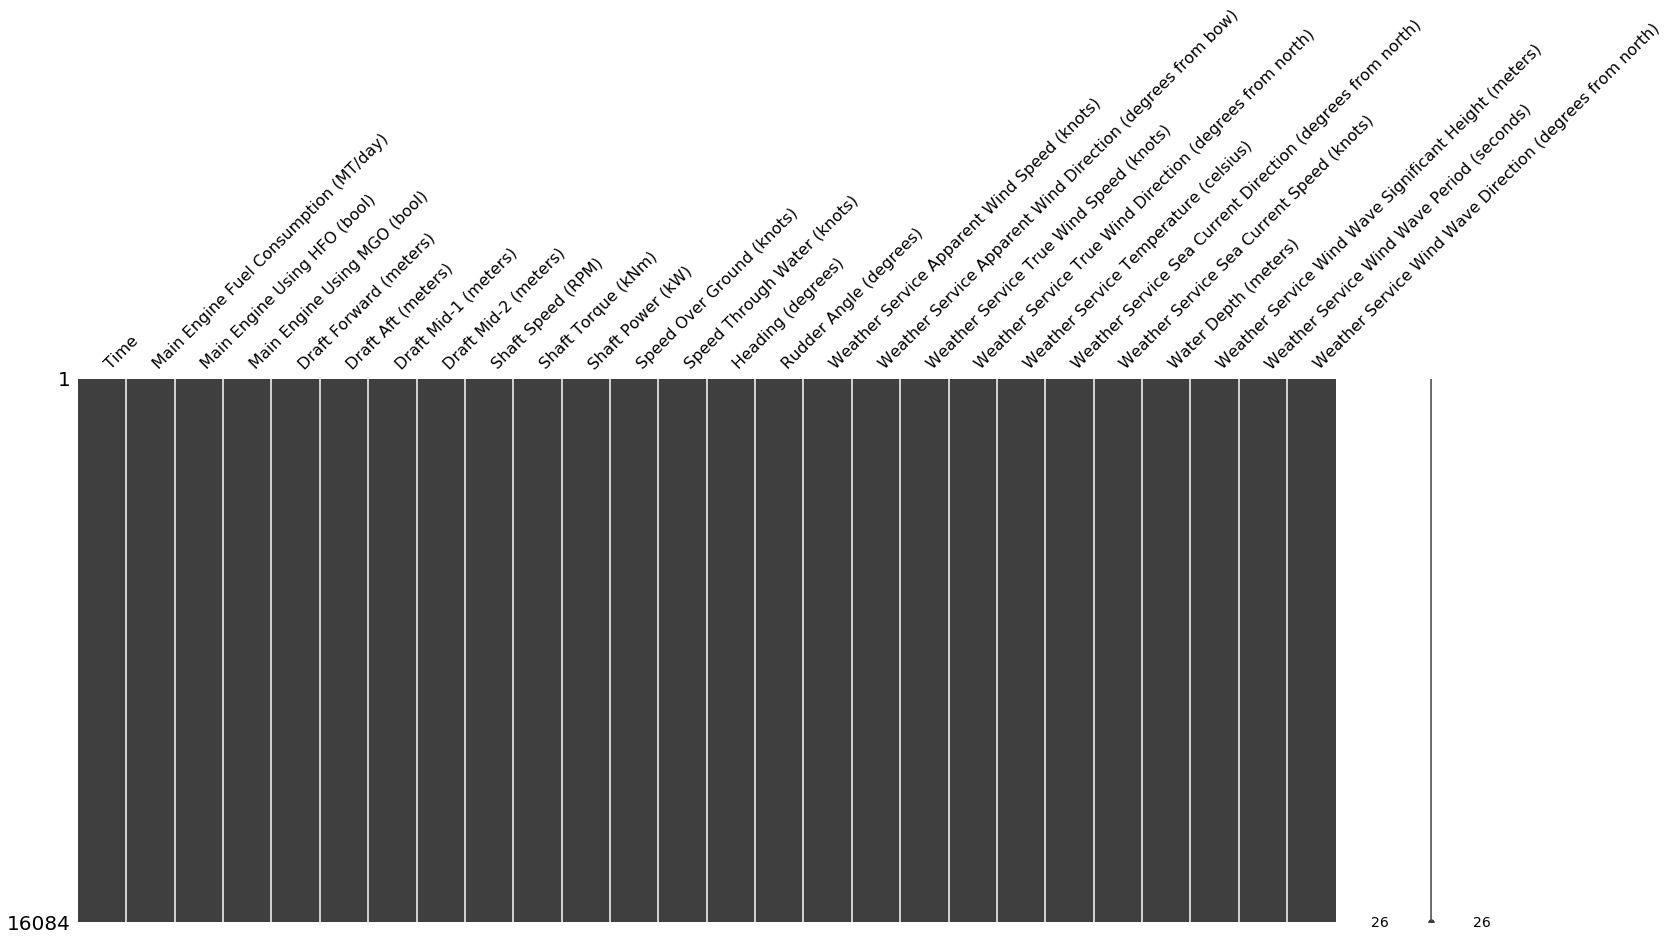

In [4]:
# Drop rows with missing target (Main Engine Fuel Consumption) ~ 1% of records
df_mod = df_raw.copy().dropna()
df_mod = df_mod.reset_index().drop('index',axis=1)
print('Percentage of missing records:   ', ((1 - df_mod.shape[0] / n_records) * 100))
print('Percentage of remaining records: ', ((    df_mod.shape[0] / n_records) * 100))
msno.matrix(df_mod)

### Time Series Visualization

In [5]:
# Create helper sublists of column names
cols_main  = df_mod.columns[0:4]
cols_draft = df_mod.columns[4:8]
cols_shaft = df_mod.columns[8:11]
cols_speed = df_mod.columns[11:15]
cols_wind  = df_mod.columns[15:19]
cols_sea   = df_mod.columns[19:23]
cols_wave  = df_mod.columns[23:26]
df_mod.shape

(16084, 26)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c1e201400>,
      dtype=object)

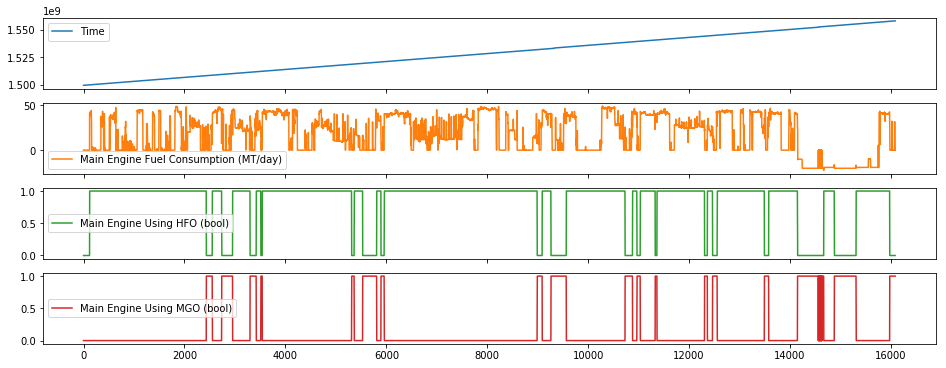

In [6]:
# Time and main engine
fig_main, axes_main = plt.subplots(len(cols_main),1, figsize=(16,len(cols_main)*1.5), sharex=True)
df_mod[cols_main].plot(subplots=True, ax=axes_main)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c1fbfb320>,
      dtype=object)

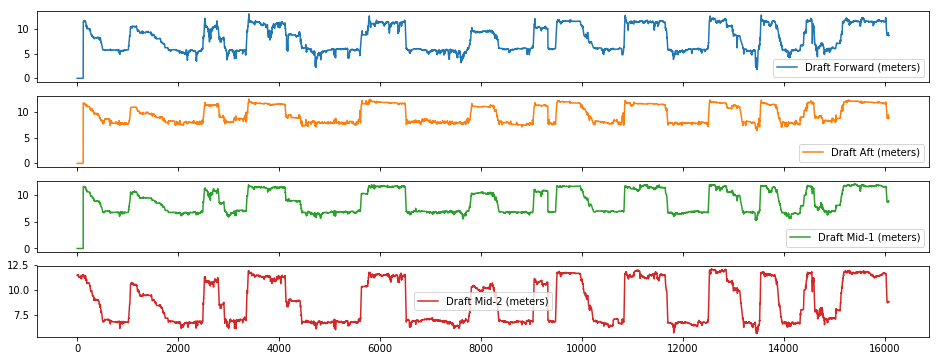

In [7]:
# Draft sensors
fig_draft, axes_draft = plt.subplots(len(cols_draft),1, figsize=(16,len(cols_draft)*1.5), sharex=True)
df_mod[cols_draft].plot(subplots=True, ax=axes_draft)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c1d7dd0f0>,
      dtype=object)

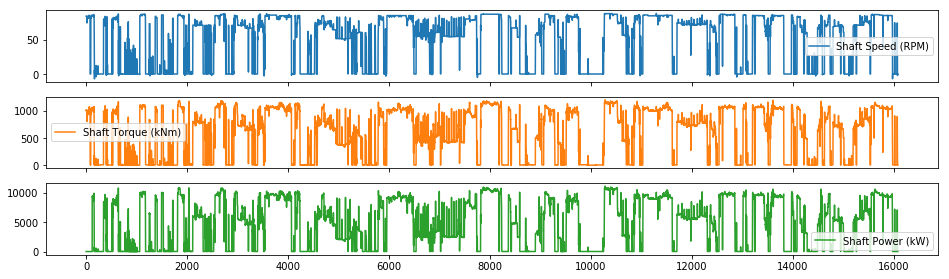

In [8]:
# Shaft performance
fig_shaft, axes_shaft = plt.subplots(len(cols_shaft),1, figsize=(16,len(cols_shaft)*1.5), sharex=True)
df_mod[cols_shaft].plot(subplots=True, ax=axes_shaft)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c1e69c198>,
      dtype=object)

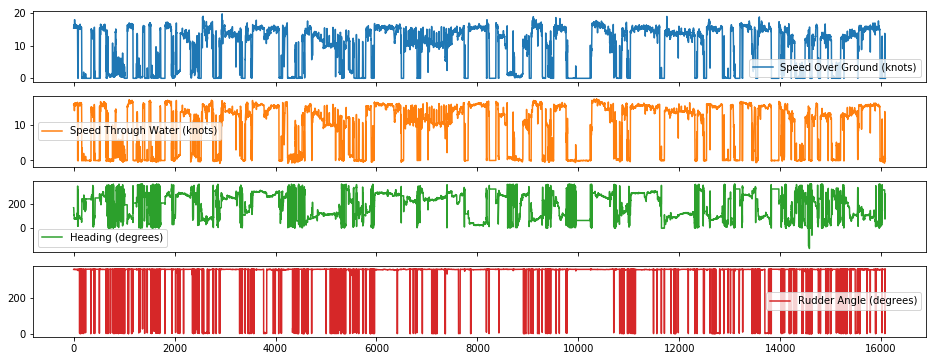

In [9]:
# Vessel speed
fig_speed, axes_speed = plt.subplots(len(cols_speed),1, figsize=(16,len(cols_speed)*1.5), sharex=True)
df_mod[cols_speed].plot(subplots=True, ax=axes_speed)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c210cd9e8>,
      dtype=object)

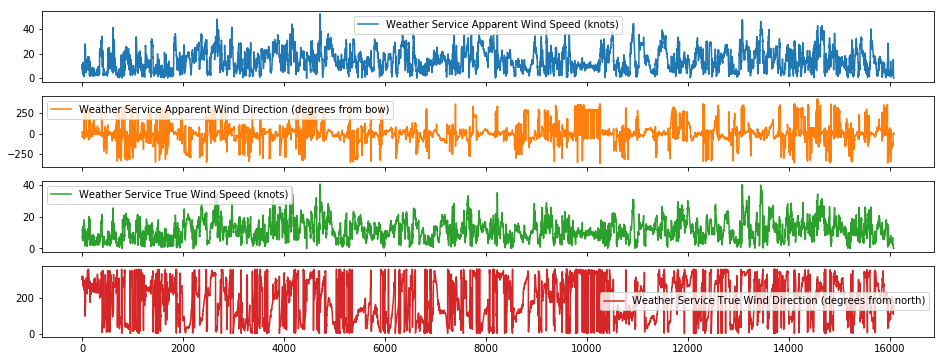

In [10]:
# Wind conditions
fig_wind, axes_wind = plt.subplots(len(cols_wind),1, figsize=(16,len(cols_wind)*1.5), sharex=True)
df_mod[cols_wind].plot(subplots=True, ax=axes_wind)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c21c41240>,
      dtype=object)

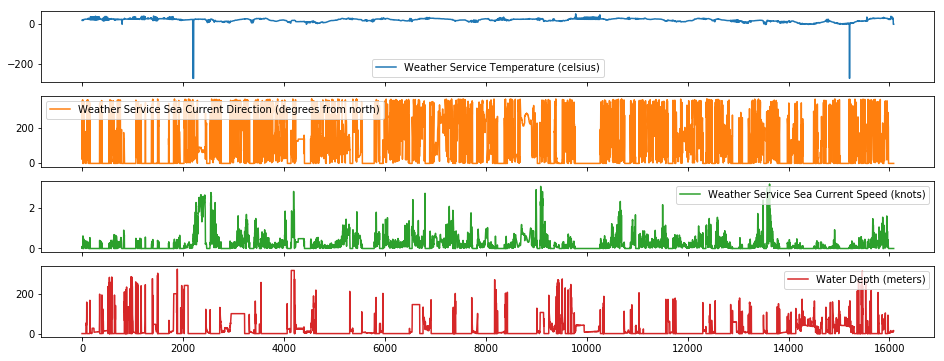

In [11]:
# Sea conditions
fig_sea, axes_sea = plt.subplots(len(cols_sea),1, figsize=(16,len(cols_sea)*1.5), sharex=True)
df_mod[cols_sea].plot(subplots=True, ax=axes_sea)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c223e9e48>,
      dtype=object)

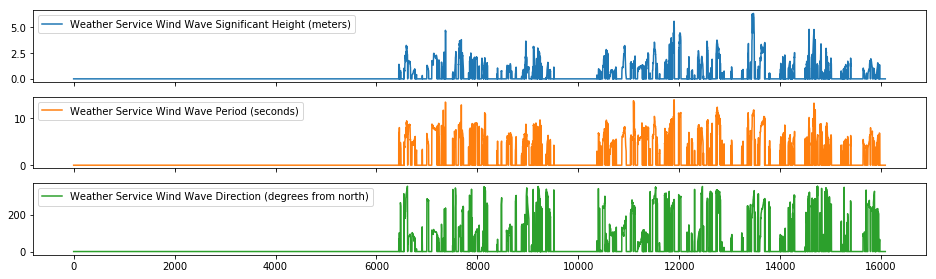

In [12]:
# Wave conditions
fig_wave, axes_wave = plt.subplots(len(cols_wave),1, figsize=(16,len(cols_wave)*1.5), sharex=True)
df_mod[cols_wave].plot(subplots=True, ax=axes_wave)

### Data Cleaning

In [13]:
# Convert Unix time to datetime format
df_mod['Time'] = pd.to_datetime(df_mod['Time'], unit='s')
df_mod['Time'].head()

0   2017-07-06 13:15:00
1   2017-07-06 14:00:00
2   2017-07-06 15:00:00
3   2017-07-06 16:00:00
4   2017-07-06 17:00:00
Name: Time, dtype: datetime64[ns]

In [14]:
# Calibrate fuel consumption with most frequent near-zero measurement (-0.048 MT/day)
print(df_mod[cols_main[1]].value_counts().head())
df_mod[cols_main[1]] -= df_mod[cols_main[1]].value_counts().index[0]

# Drop records with negative fuel consumption ~ 16.2% of records
cutoff = 0.0
print('Percentage of records with negative consumption: ',
      df_mod[df_mod[cols_main[1]] < cutoff].shape[0] / n_records * 100)
df_mod = df_mod.drop(df_mod[df_mod[cols_main[1]] < cutoff].index)
df_mod = df_mod.reset_index().drop('index',axis=1)
print('Percentage of remaining records:                 ', ((df_mod.shape[0] / n_records) * 100))

-0.048000     2105
-20.193103     829
-19.200000     617
-0.050483      526
 0.000000      149
Name: Main Engine Fuel Consumption (MT/day), dtype: int64
Percentage of records with negative consumption:  16.235844411619894
Percentage of remaining records:                  82.75480059084195


In [15]:
# Revert HFO and MGO to booleans (unbalanced value counts)
print(df_mod[cols_main[2]].value_counts())
df_mod[cols_main[2]] = df_mod[cols_main[2]].astype('int64')
df_mod[cols_main[3]] = df_mod[cols_main[3]].astype('int64')

# Check that only one fuel gauge is indicated at a time 
df_mod['Fuel Gauge'] = df_mod[cols_main[2]] + df_mod[cols_main[3]]
print(df_mod['Fuel Gauge'].value_counts())

# Drop records with neither HFO nor MGO indicator ~ 1.1% of records
print('Percentage of records with no fuel indicator: ',
      df_mod[df_mod['Fuel Gauge'] == 0].shape[0] / n_records * 100)
df_mod = df_mod.drop(df_mod[df_mod['Fuel Gauge'] == 0].index)
df_mod = df_mod.reset_index().drop('index',axis=1)
print('Percentage of remaining records:              ', ((df_mod.shape[0] / n_records) * 100))

1.000000    12456
0.000000      961
0.583333        4
0.083333        3
0.250000        3
0.666667        3
0.750000        2
0.083333        2
0.500000        2
0.166667        2
0.916667        1
0.833333        1
0.416667        1
0.833333        1
0.333333        1
0.583333        1
0.416667        1
0.333333        1
Name: Main Engine Using HFO (bool), dtype: int64
1    13265
0      181
Name: Fuel Gauge, dtype: int64
Percentage of records with no fuel indicator:  1.1139832594780896
Percentage of remaining records:               81.64081733136386


array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c22dd41d0>,
      dtype=object)

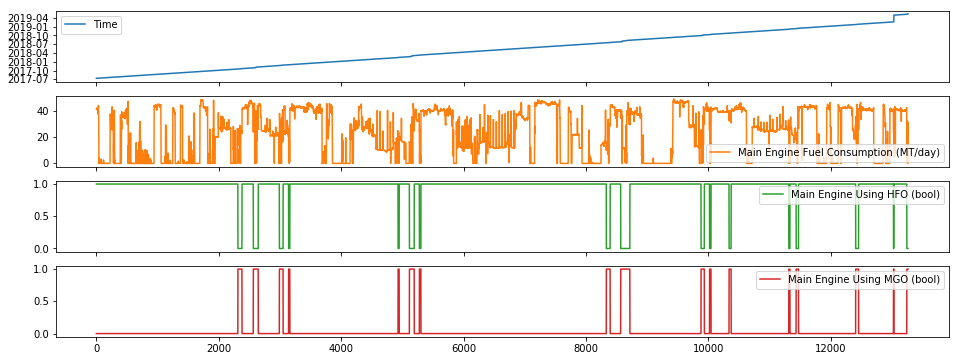

In [16]:
# Time and main engine (cleaned)
fig_main, axes_main = plt.subplots(len(cols_main),1, figsize=(16,len(cols_main)*1.5), sharex=True)
df_mod[cols_main].plot(subplots=True, ax=axes_main)

In [17]:
# Make rudder data continuous by using -180 to 180 degree angles
degrees = 360
print(df_mod[cols_speed[3]].value_counts().sort_index(ascending=False).head())
df_mod.loc[df_mod[cols_speed[3]] > 180, cols_speed[3]] -= degrees

359.999195    1
359.998022    1
359.997018    1
359.996044    1
359.994729    1
Name: Rudder Angle (degrees), dtype: int64


array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c223dfba8>,
      dtype=object)

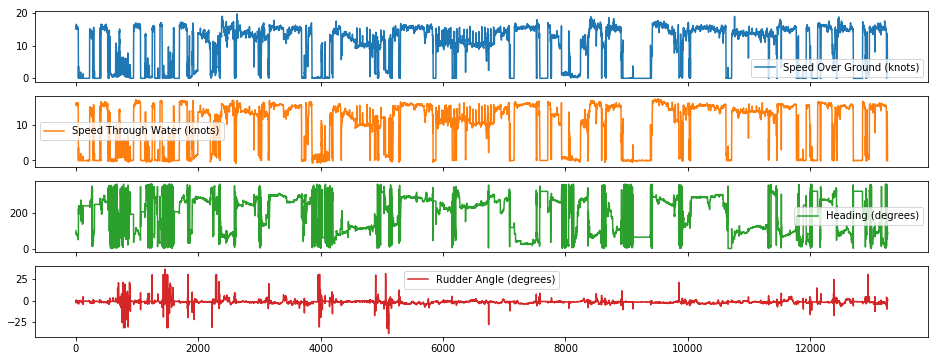

In [18]:
# Vessel speed (cleaned)
fig_speed, axes_speed = plt.subplots(len(cols_speed),1, figsize=(16,len(cols_speed)*1.5), sharex=True)
df_mod[cols_speed].plot(subplots=True, ax=axes_speed)

In [19]:
# Replace 0.0 apparent wind speed records with median
print(df_mod[cols_wind[0]].value_counts().sort_index().head())
df_mod.loc[df_mod[cols_wind[0]] == 0, cols_wind[0]] = df_mod[df_mod[cols_wind[0]] > 0][cols_wind[0]].median()

0.000000    6
0.216047    1
0.287470    1
0.327147    1
0.334764    1
Name: Weather Service Apparent Wind Speed (knots), dtype: int64


In [20]:
# Replace 0.0 apparent wind direction records with median
print(df_mod[cols_wind[1]].value_counts().head())
df_mod.loc[df_mod[cols_wind[1]] == 0, cols_wind[1]] = df_mod[df_mod[cols_wind[1]] > 0][cols_wind[1]].median()

 0.000000      15
 22.435300      6
 282.731640     6
-166.161982     6
 71.954857      6
Name: Weather Service Apparent Wind Direction (degrees from bow), dtype: int64


In [21]:
# Replace 0.0 true wind speed records with median
print(df_mod[cols_wind[2]].value_counts().head())
df_mod.loc[df_mod[cols_wind[2]] == 0, cols_wind[2]] = df_mod[df_mod[cols_wind[2]] > 0][cols_wind[2]].median()

0.000000    35
9.470054     6
2.623480     6
6.939681     6
3.391007     6
Name: Weather Service True Wind Speed (knots), dtype: int64


In [22]:
# Replace 180.0 true wind direction records with median
print(df_mod[cols_wind[3]].value_counts().head())
df_mod.loc[df_mod[cols_wind[3]] == 180, cols_wind[3]] = df_mod[df_mod[cols_wind[3]] != 180][cols_wind[3]].median()

180.000000    35
256.170574     6
337.737234     6
94.635519      6
327.657257     6
Name: Weather Service True Wind Direction (degrees from north), dtype: int64


array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c244691d0>,
      dtype=object)

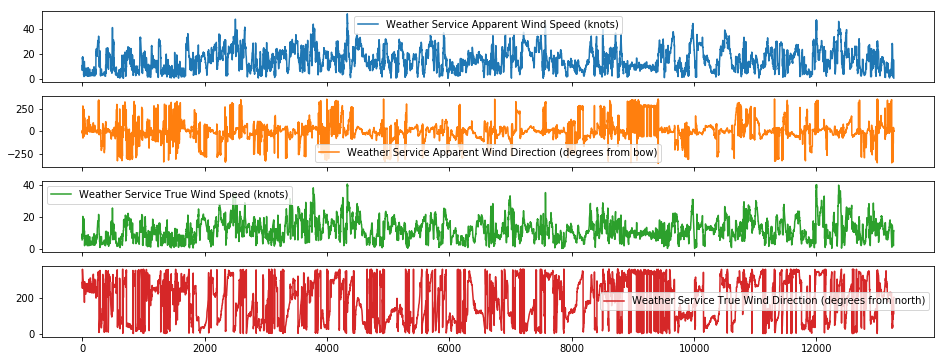

In [23]:
# Wind conditions (cleaned)
fig_wind, axes_wind = plt.subplots(len(cols_wind),1, figsize=(16,len(cols_wind)*1.5), sharex=True)
df_mod[cols_wind].plot(subplots=True, ax=axes_wind)

In [24]:
# Replace non-positive temperature records with median
print(df_mod[cols_sea[0]].value_counts().sort_index().head())
df_mod.loc[df_mod[cols_sea[0]] <= 0, cols_sea[0]] = df_mod[df_mod[cols_sea[0]] > 0][cols_sea[0]].median()

-273.150000    18
-1.055194       1
 0.000000      17
 1.646941       1
 2.553591       1
Name: Weather Service Temperature (celsius), dtype: int64


In [25]:
# Replace 0.0 sea current direction records with median
print(df_mod[cols_sea[1]].value_counts().head())
df_mod.loc[df_mod[cols_sea[1]] == 0, cols_sea[1]] = df_mod[df_mod[cols_sea[1]] > 0][cols_sea[1]].median()

0.000000      3605
135.747399      52
135.371942      41
180.000000      17
124.335964      17
Name: Weather Service Sea Current Direction (degrees from north), dtype: int64


In [26]:
# Replace 0.0 sea current speed records with median
print(df_mod[cols_sea[2]].value_counts().head())
df_mod.loc[df_mod[cols_sea[2]] == 0, cols_sea[2]] = df_mod[df_mod[cols_sea[2]] > 0][cols_sea[2]].median()

0.000000    3585
0.484691      52
0.486996      41
0.306027      17
0.311248      13
Name: Weather Service Sea Current Speed (knots), dtype: int64


array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c253b60f0>,
      dtype=object)

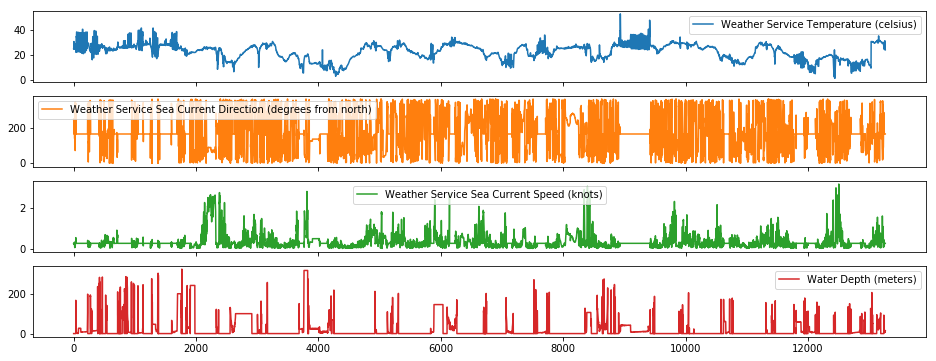

In [27]:
# Sea conditions (cleaned)
fig_sea, axes_sea = plt.subplots(len(cols_sea),1, figsize=(16,len(cols_sea)*1.5), sharex=True)
df_mod[cols_sea].plot(subplots=True, ax=axes_sea)

In [28]:
# Replace 0.0 wave height records with median
print(df_mod[cols_wave[0]].value_counts().head())
df_mod.loc[df_mod[cols_wave[0]] == 0, cols_wave[0]] = df_mod[df_mod[cols_wave[0]] > 0][cols_wave[0]].median()

0.000000    10661
0.730200        2
0.885000        2
0.728111        2
0.507999        2
Name: Weather Service Wind Wave Significant Height (meters), dtype: int64


In [29]:
# Replace 0.0 wave period records with median
print(df_mod[cols_wave[1]].value_counts().head())
df_mod.loc[df_mod[cols_wave[1]] == 0, cols_wave[1]] = df_mod[df_mod[cols_wave[1]] > 0][cols_wave[1]].median()

0.000    10661
8.960        4
4.112        2
4.508        2
8.940        2
Name: Weather Service Wind Wave Period (seconds), dtype: int64


In [30]:
# Replace 0.0 wave direction records with median
print(df_mod[cols_wave[2]].value_counts().head())
df_mod.loc[df_mod[cols_wave[2]] == 0, cols_wave[2]] = df_mod[df_mod[cols_wave[2]] > 0][cols_wave[2]].median()

0.000000      10661
106.875778        2
128.138668        2
106.835260        2
301.478925        1
Name: Weather Service Wind Wave Direction (degrees from north), dtype: int64


array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c25df7438>,
      dtype=object)

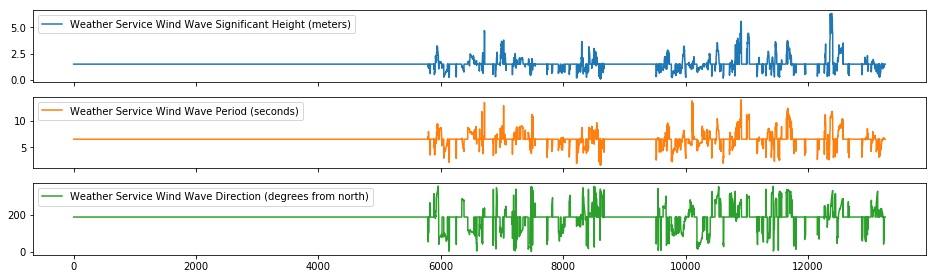

In [31]:
# Wave conditions (cleaned)
fig_wave, axes_wave = plt.subplots(len(cols_wave),1, figsize=(16,len(cols_wave)*1.5), sharex=True)
df_mod[cols_wave].plot(subplots=True, ax=axes_wave)

### Outliers

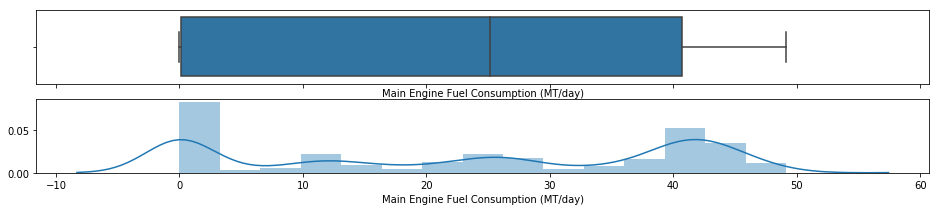

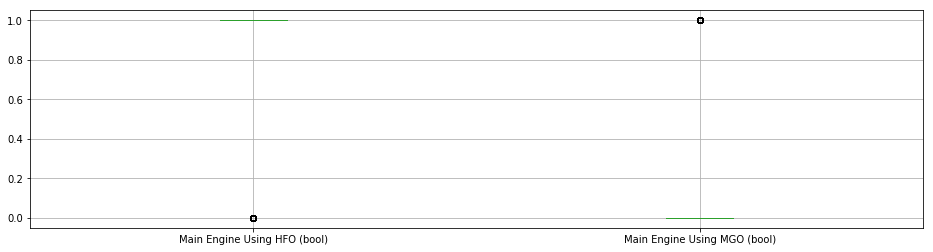

In [32]:
# Main engine fuel consumption
f, (ax_box, ax_hist) = plt.subplots(2, figsize=(16,2*1.5), sharex=True)
sns.boxplot( df_mod[cols_main[1]], ax=ax_box)
sns.distplot(df_mod[cols_main[1]], ax=ax_hist)

# Fuel source
plt.figure("Boxplot", figsize=(16,4))
df_mod[cols_main[2:4]].boxplot()

Percentage of low fuel consumption records:  50.473904480551454
Percentage of remaining records:             31.166912850812405


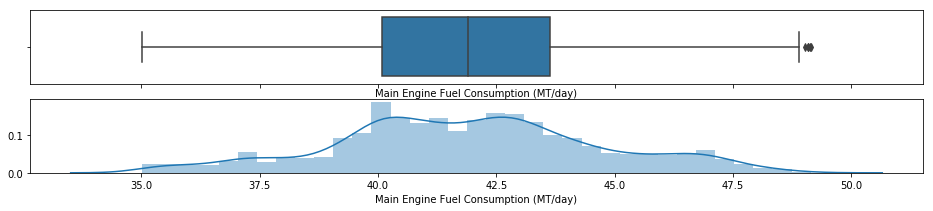

In [33]:
# Drop records with low fuel consumption (less than 5 MT/day) ~ 22.4% of records
cutoff = 35
print('Percentage of low fuel consumption records: ',
      df_mod[df_mod[cols_main[1]] < cutoff].shape[0] / n_records * 100)
df_mod = df_mod.drop(df_mod[df_mod[cols_main[1]] < cutoff].index)
df_mod = df_mod.reset_index().drop('index',axis=1)
print('Percentage of remaining records:            ', ((df_mod.shape[0] / n_records) * 100))

# Main engine fuel consumption
f, (ax_box, ax_hist) = plt.subplots(2, figsize=(16,2*1.5), sharex=True)
sns.boxplot( df_mod[cols_main[1]], ax=ax_box)
sns.distplot(df_mod[cols_main[1]], ax=ax_hist)

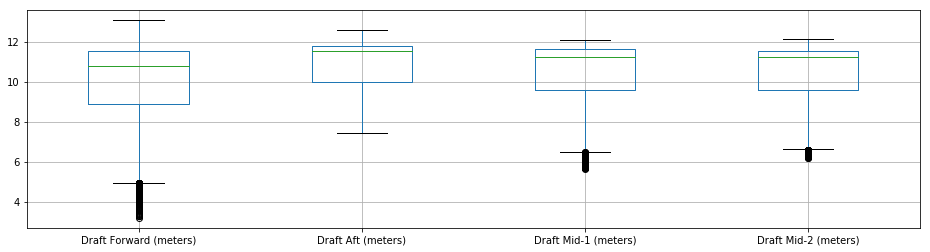

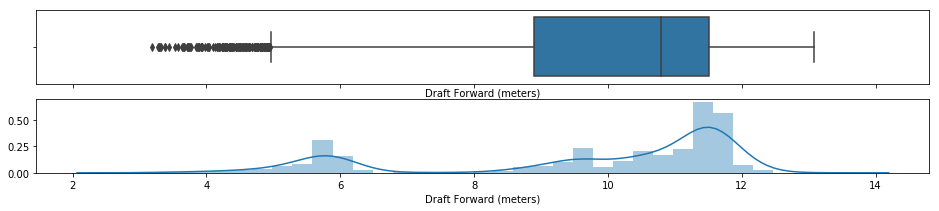

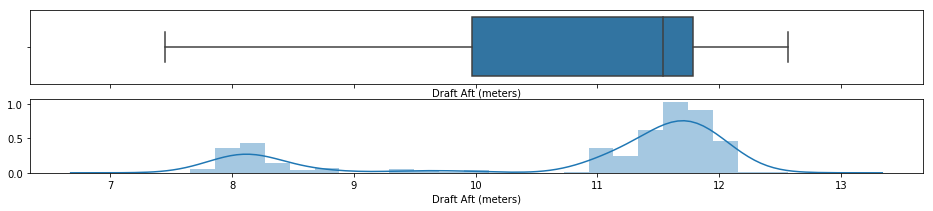

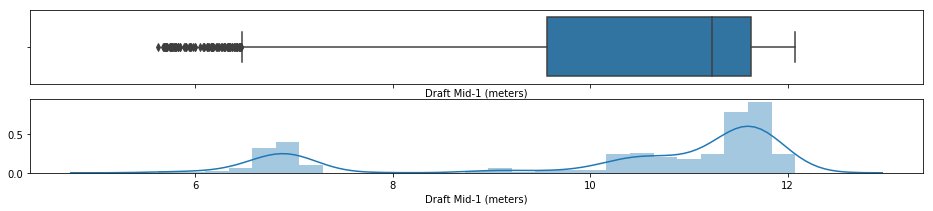

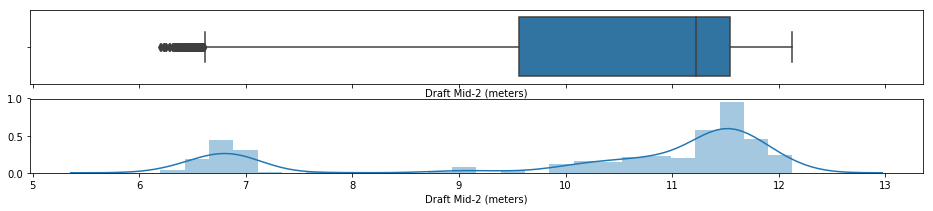

In [34]:
# Draft sensors
plt.figure("Boxplot", figsize=(16,4))
df_mod[cols_draft].boxplot()

# Forward draft sensor
f, (ax_box, ax_hist) = plt.subplots(2, figsize=(16,2*1.5), sharex=True)
sns.boxplot( df_mod[cols_draft[0]], ax=ax_box)
sns.distplot(df_mod[cols_draft[0]], ax=ax_hist)

# Aft draft sensor
f, (ax_box, ax_hist) = plt.subplots(2, figsize=(16,2*1.5), sharex=True)
sns.boxplot( df_mod[cols_draft[1]], ax=ax_box)
sns.distplot(df_mod[cols_draft[1]], ax=ax_hist)

# Mid-1 draft sensor
f, (ax_box, ax_hist) = plt.subplots(2, figsize=(16,2*1.5), sharex=True)
sns.boxplot( df_mod[cols_draft[2]], ax=ax_box)
sns.distplot(df_mod[cols_draft[2]], ax=ax_hist)

# Mid-2 draft sensor
f, (ax_box, ax_hist) = plt.subplots(2, figsize=(16,2*1.5), sharex=True)
sns.boxplot( df_mod[cols_draft[3]], ax=ax_box)
sns.distplot(df_mod[cols_draft[3]], ax=ax_hist)

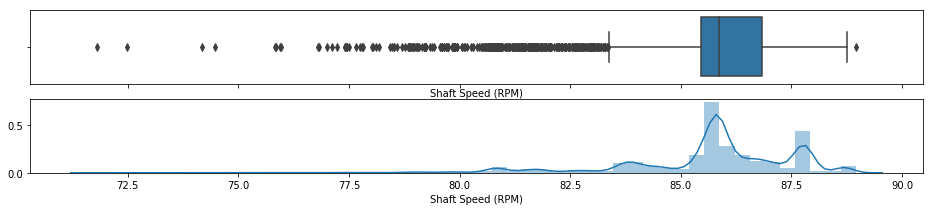

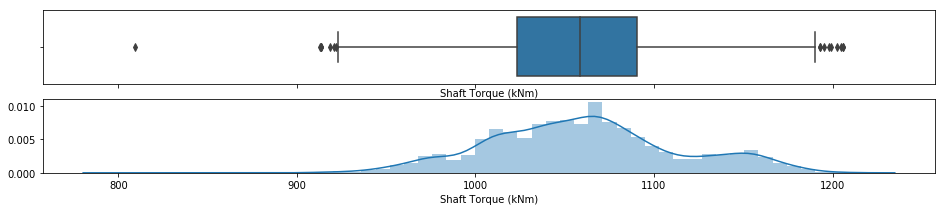

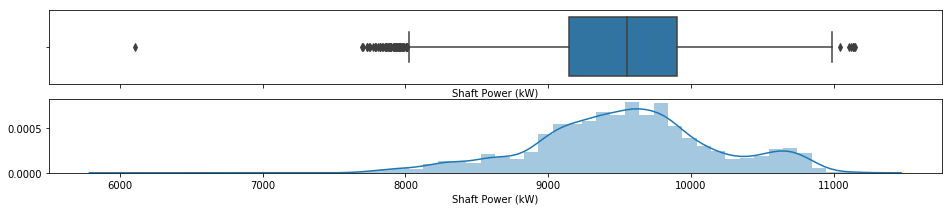

In [35]:
# Shaft speed
f, (ax_box, ax_hist) = plt.subplots(2, figsize=(16,2*1.5), sharex=True)
sns.boxplot( df_mod[cols_shaft[0]], ax=ax_box)
sns.distplot(df_mod[cols_shaft[0]], ax=ax_hist)

# Shaft torque
f, (ax_box, ax_hist) = plt.subplots(2, figsize=(16,2*1.5), sharex=True)
sns.boxplot( df_mod[cols_shaft[1]], ax=ax_box)
sns.distplot(df_mod[cols_shaft[1]], ax=ax_hist)

# Shaft power
f, (ax_box, ax_hist) = plt.subplots(2, figsize=(16,2*1.5), sharex=True)
sns.boxplot( df_mod[cols_shaft[2]], ax=ax_box)
sns.distplot(df_mod[cols_shaft[2]], ax=ax_hist)

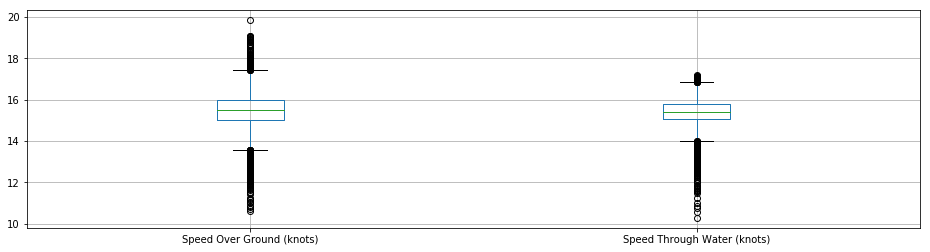

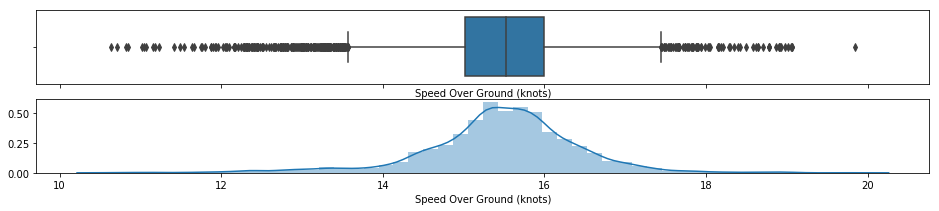

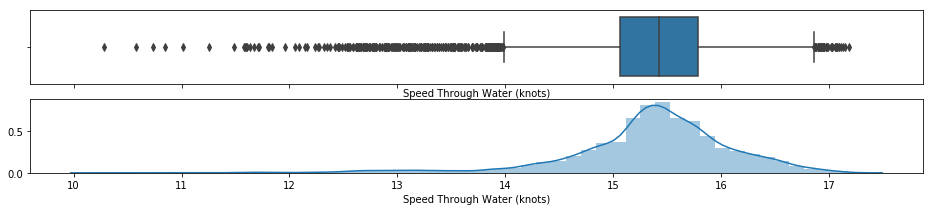

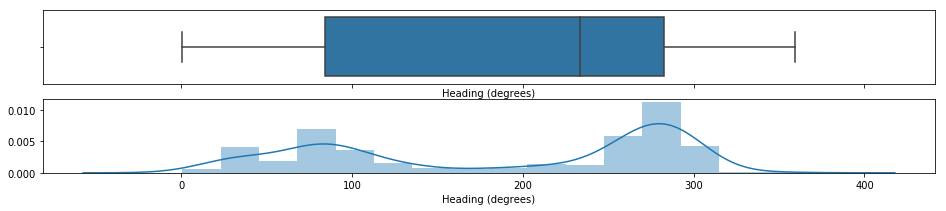

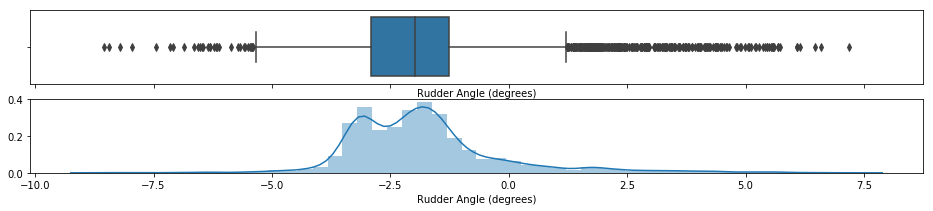

In [36]:
# Vessel speed
plt.figure("Boxplot", figsize=(16,4))
df_mod[cols_speed[0:2]].boxplot()

# Speed over ground
f, (ax_box, ax_hist) = plt.subplots(2, figsize=(16,2*1.5), sharex=True)
sns.boxplot( df_mod[cols_speed[0]], ax=ax_box)
sns.distplot(df_mod[cols_speed[0]], ax=ax_hist)

# Speed through water
f, (ax_box, ax_hist) = plt.subplots(2, figsize=(16,2*1.5), sharex=True)
sns.boxplot( df_mod[cols_speed[1]], ax=ax_box)
sns.distplot(df_mod[cols_speed[1]], ax=ax_hist)

# Heading angle
f, (ax_box, ax_hist) = plt.subplots(2, figsize=(16,2*1.5), sharex=True)
sns.boxplot( df_mod[cols_speed[2]], ax=ax_box)
sns.distplot(df_mod[cols_speed[2]], ax=ax_hist)

# Rudder angle
f, (ax_box, ax_hist) = plt.subplots(2, figsize=(16,2*1.5), sharex=True)
sns.boxplot( df_mod[cols_speed[3]], ax=ax_box)
sns.distplot(df_mod[cols_speed[3]], ax=ax_hist)

Percentage of low speed over ground records:   0.0
Percentage of high speed over ground records:  0.20310192023633677
Percentage of remaining records:               30.96381093057607


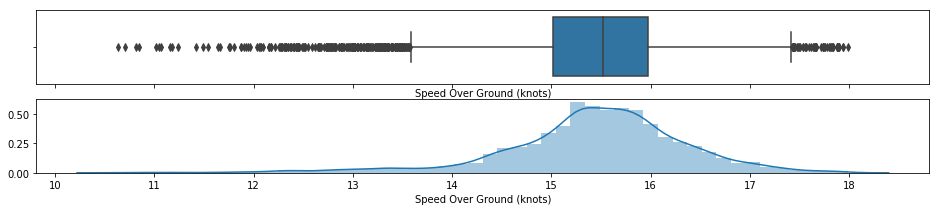

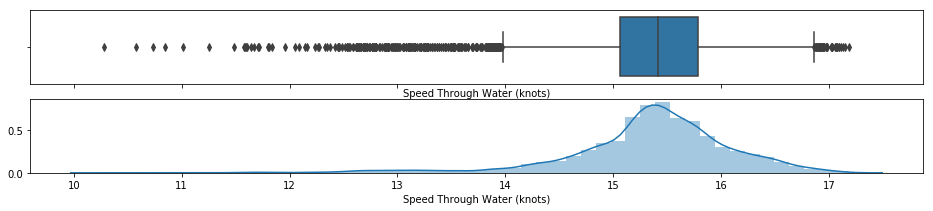

In [37]:
# Drop records with low speed over ground (less than 9 knots) ~ 1.2% of records
cutoff = 9
print('Percentage of low speed over ground records:  ',
      df_mod[df_mod[cols_speed[0]] < cutoff].shape[0] / n_records * 100)
df_mod = df_mod.drop(df_mod[df_mod[cols_speed[0]] < cutoff].index)

# Drop records with high speed over ground (more than 18 knots) ~ 0.2% of records
cutoff = 18
print('Percentage of high speed over ground records: ',
      df_mod[df_mod[cols_speed[0]] > cutoff].shape[0] / n_records * 100)
df_mod = df_mod.drop(df_mod[df_mod[cols_speed[0]] > cutoff].index)
df_mod = df_mod.reset_index().drop('index',axis=1)
print('Percentage of remaining records:              ', ((df_mod.shape[0] / n_records) * 100))

# Speed over ground
f, (ax_box, ax_hist) = plt.subplots(2, figsize=(16,2*1.5), sharex=True)
sns.boxplot( df_mod[cols_speed[0]], ax=ax_box)
sns.distplot(df_mod[cols_speed[0]], ax=ax_hist)

# Speed through water
f, (ax_box, ax_hist) = plt.subplots(2, figsize=(16,2*1.5), sharex=True)
sns.boxplot( df_mod[cols_speed[1]], ax=ax_box)
sns.distplot(df_mod[cols_speed[1]], ax=ax_hist)

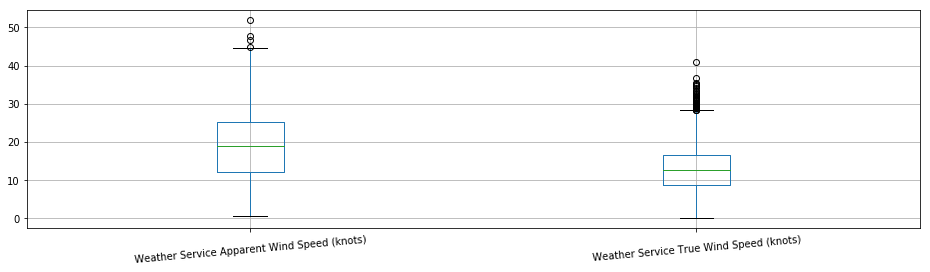

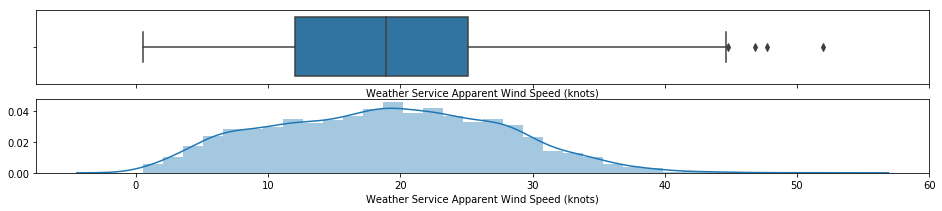

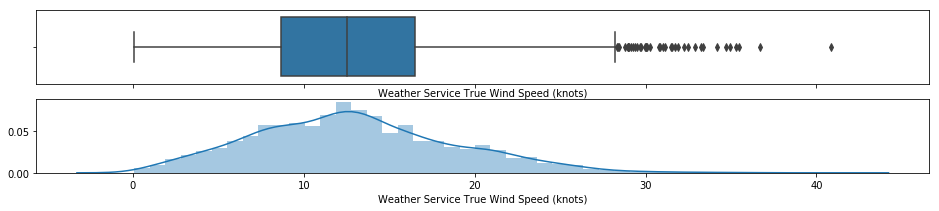

In [38]:
# Wind speed
plt.figure("Boxplot", figsize=(16,4))
df_mod[[cols_wind[0],cols_wind[2]]].boxplot()
plt.xticks(rotation=5)

# Apparent wind speed
f, (ax_box, ax_hist) = plt.subplots(2, figsize=(16,2*1.5), sharex=True)
sns.boxplot( df_mod[cols_wind[0]], ax=ax_box)
sns.distplot(df_mod[cols_wind[0]], ax=ax_hist)

# True wind speed
f, (ax_box, ax_hist) = plt.subplots(2, figsize=(16,2*1.5), sharex=True)
sns.boxplot( df_mod[cols_wind[2]], ax=ax_box)
sns.distplot(df_mod[cols_wind[2]], ax=ax_hist)

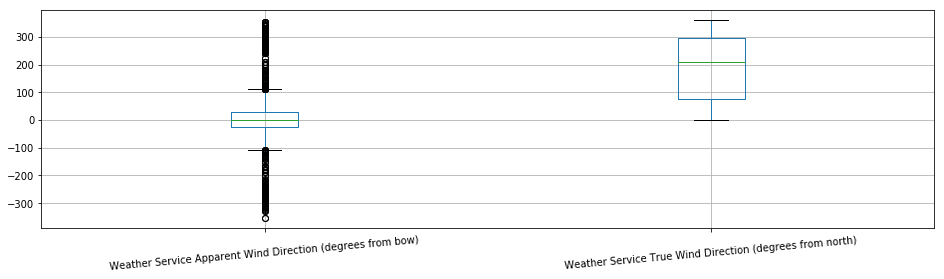

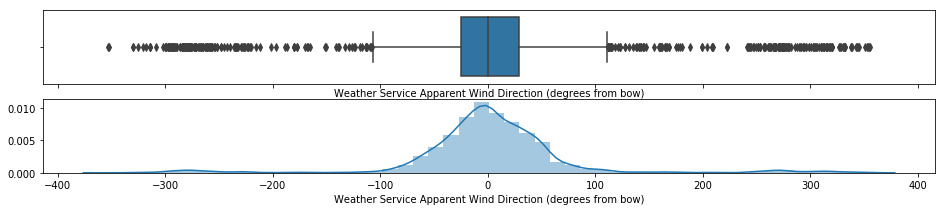

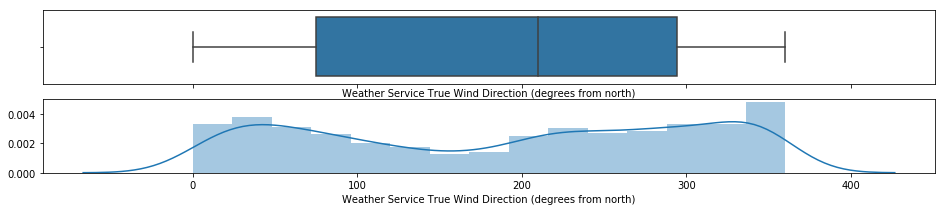

In [39]:
# Wind direction
plt.figure("Boxplot", figsize=(16,4))
df_mod[[cols_wind[1],cols_wind[3]]].boxplot()
plt.xticks(rotation=5)

# Apparent wind direction
f, (ax_box, ax_hist) = plt.subplots(2, figsize=(16,2*1.5), sharex=True)
sns.boxplot( df_mod[cols_wind[1]], ax=ax_box)
sns.distplot(df_mod[cols_wind[1]], ax=ax_hist)

# True wind direction
f, (ax_box, ax_hist) = plt.subplots(2, figsize=(16,2*1.5), sharex=True)
sns.boxplot( df_mod[cols_wind[3]], ax=ax_box)
sns.distplot(df_mod[cols_wind[3]], ax=ax_hist)

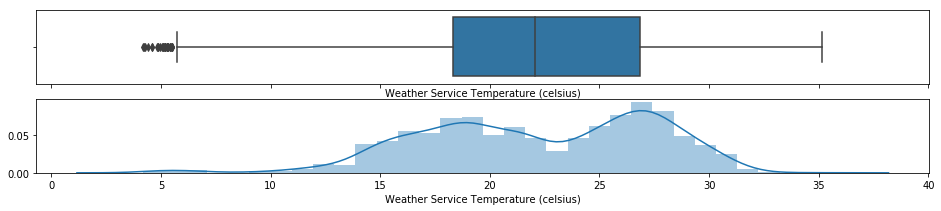

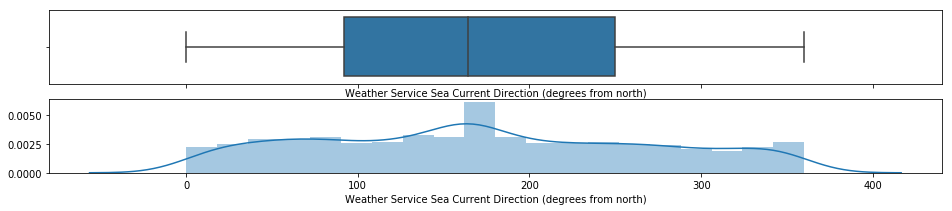

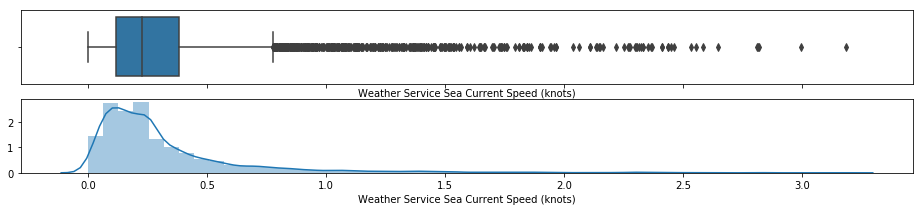

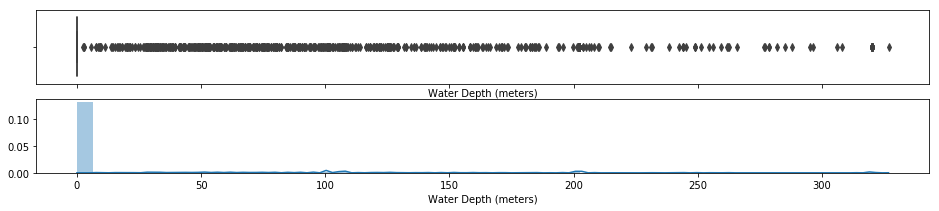

In [40]:
# Sea temperature
f, (ax_box, ax_hist) = plt.subplots(2, figsize=(16,2*1.5), sharex=True)
sns.boxplot( df_mod[cols_sea[0]], ax=ax_box)
sns.distplot(df_mod[cols_sea[0]], ax=ax_hist)

# Sea current direction
f, (ax_box, ax_hist) = plt.subplots(2, figsize=(16,2*1.5), sharex=True)
sns.boxplot( df_mod[cols_sea[1]], ax=ax_box)
sns.distplot(df_mod[cols_sea[1]], ax=ax_hist)

# Sea current speed
f, (ax_box, ax_hist) = plt.subplots(2, figsize=(16,2*1.5), sharex=True)
sns.boxplot( df_mod[cols_sea[2]], ax=ax_box)
sns.distplot(df_mod[cols_sea[2]], ax=ax_hist)

# Sea water depth
f, (ax_box, ax_hist) = plt.subplots(2, figsize=(16,2*1.5), sharex=True)
sns.boxplot( df_mod[cols_sea[3]], ax=ax_box)
sns.distplot(df_mod[cols_sea[3]], ax=ax_hist)

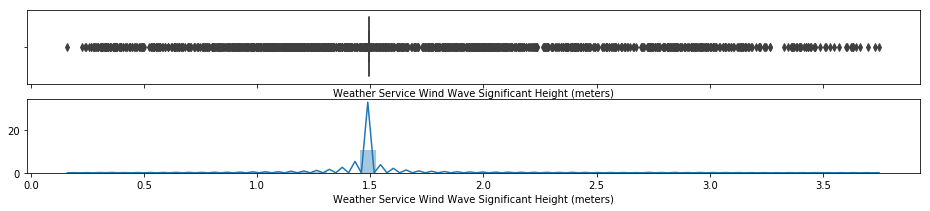

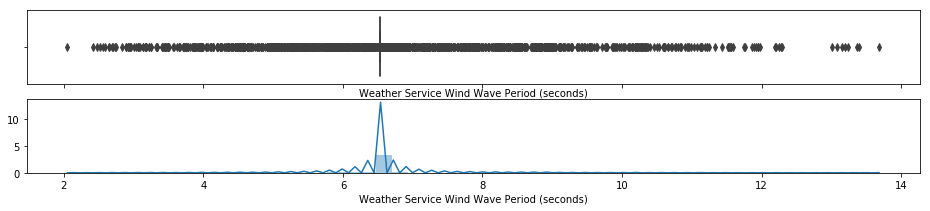

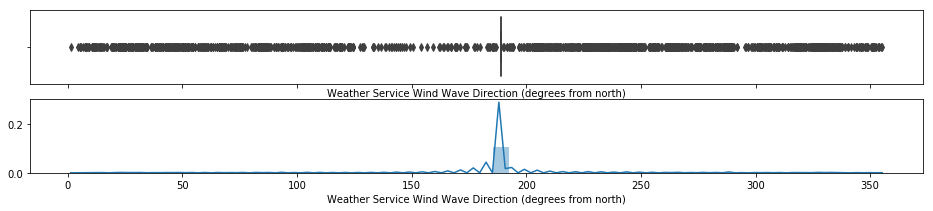

In [41]:
# Wave height
f, (ax_box, ax_hist) = plt.subplots(2, figsize=(16,2*1.5), sharex=True)
sns.boxplot( df_mod[cols_wave[0]], ax=ax_box)
sns.distplot(df_mod[cols_wave[0]], ax=ax_hist)

# Wave period
f, (ax_box, ax_hist) = plt.subplots(2, figsize=(16,2*1.5), sharex=True)
sns.boxplot( df_mod[cols_wave[1]], ax=ax_box)
sns.distplot(df_mod[cols_wave[1]], ax=ax_hist)

# Wave direction
f, (ax_box, ax_hist) = plt.subplots(2, figsize=(16,2*1.5), sharex=True)
sns.boxplot( df_mod[cols_wave[2]], ax=ax_box)
sns.distplot(df_mod[cols_wave[2]], ax=ax_hist)

# Exploratory Data Analysis

In [42]:
# Time and main engine
df_mod[cols_main].describe()

,Main Engine Fuel Consumption (MT/day),Main Engine Using HFO (bool),Main Engine Using MGO (bool)
count,5031.000000,5031.000000,5031.000000
mean,41.901358,0.956867,0.043133
std,2.803113,0.203176,0.203176
min,35.020310,0.000000,0.000000
25%,40.084320,1.000000,0.000000
50%,41.887586,1.000000,0.000000
75%,43.638392,1.000000,0.000000
max,49.138823,1.000000,1.000000


In [43]:
# Draft sensors
df_mod[cols_draft].describe()

,Draft Forward (meters),Draft Aft (meters),Draft Mid-1 (meters),Draft Mid-2 (meters)
count,5031.000000,5031.000000,5031.000000,5031.000000
mean,9.693522,10.787039,10.217730,10.202834
std,2.390548,1.485971,1.929150,1.936617
min,3.189212,7.449330,5.619919,6.198983
25%,8.877956,9.964324,9.556850,9.564339
50%,10.799718,11.538565,11.239899,11.229180
75%,11.513271,11.779809,11.625261,11.537157
max,13.073286,12.563152,12.076237,12.127948


In [44]:
# Shaft performance
df_mod[cols_shaft].describe()

,Shaft Speed (RPM),Shaft Torque (kNm),Shaft Power (kW)
count,5031.000000,5031.000000,5031.000000
mean,85.669428,1060.526504,9539.768050
std,1.957564,53.181094,635.753147
min,71.800805,809.103992,6108.763311
25%,85.452077,1022.966773,9144.677316
50%,85.852245,1058.575841,9549.198260
75%,86.838710,1090.760806,9905.227937
max,88.959431,1206.091541,11150.041983


In [45]:
# Vessel speed
df_mod[cols_speed].describe()

,Speed Over Ground (knots),Speed Through Water (knots),Heading (degrees),Rudder Angle (degrees)
count,5031.000000,5031.000000,5031.000000,5031.000000
mean,15.440144,15.351204,186.637800,-1.786870
std,0.931764,0.772846,100.758742,1.656480
min,10.630995,10.280222,0.705932,-8.544793
25%,15.017522,15.060661,84.860595,-2.915625
50%,15.514546,15.419904,237.253155,-1.988639
75%,15.976950,15.783082,282.924233,-1.274932
max,17.986753,17.186902,359.598646,7.182312


In [46]:
# Wind conditions
df_mod[cols_wind].describe()

,Weather Service Apparent Wind Speed (knots),Weather Service Apparent Wind Direction (degrees from bow),Weather Service True Wind Speed (knots),Weather Service True Wind Direction (degrees from north)
count,5031.000000,5031.000000,5031.000000,5031.000000
mean,18.766623,2.477268,12.952868,189.166075
std,8.607971,75.679792,5.888384,115.482558
min,0.510128,-353.102871,0.101246,0.000568
25%,12.041469,-25.425767,8.670340,74.718344
50%,18.887219,0.066570,12.540788,210.023022
75%,25.117697,29.169636,16.537312,294.478907
max,51.955335,355.024665,40.845838,359.997076


In [47]:
# Sea conditions
df_mod[cols_sea].describe()

,Weather Service Temperature (celsius),Weather Service Sea Current Direction (degrees from north),Weather Service Sea Current Speed (knots),Water Depth (meters)
count,5031.000000,5031.000000,5031.000000,5031.000000
mean,22.232071,173.034357,0.327975,15.538611
std,5.251661,97.665144,0.353952,47.931495
min,4.203276,0.239671,0.000472,0.000000
25%,18.314710,91.813445,0.120300,0.000000
50%,22.080376,164.252684,0.227839,0.000000
75%,26.837884,249.950720,0.382827,0.000000
max,35.152033,359.999716,3.184603,326.803230


In [48]:
# Wave conditions
df_mod[cols_wave].describe()

,Weather Service Wind Wave Significant Height (meters),Weather Service Wind Wave Period (seconds),Weather Service Wind Wave Direction (degrees from north)
count,5031.000000,5031.000000,5031.000000
mean,1.541153,6.620591,188.756746
std,0.422206,1.040000,53.851106
min,0.161845,2.050688,1.275837
25%,1.494357,6.536767,188.775385
50%,1.494357,6.536767,188.775385
75%,1.494357,6.536767,188.775385
max,3.748019,13.683601,355.290523


In [49]:
# Explore fuel consumption by fuel source
df_hfo = df_mod[df_mod[cols_main[2]] == 1].copy()
df_hfo['Fuel'] = 'Main Engine Using HFO'

df_mgo = df_mod[df_mod[cols_main[3]] == 1].copy()
df_mgo['Fuel'] = 'Main Engine Using MGO'

# Drop records with zero fuel consumption (for EDA only)
df_fuel = pd.concat([df_hfo, df_mgo])
df_fuel = df_fuel[df_fuel[cols_main[1]] > 0]

In [50]:
# Print mean fuel consumption by fuel source
df_fuel.groupby('Fuel')[cols_main].median()

,Main Engine Fuel Consumption (MT/day),Main Engine Using HFO (bool),Main Engine Using MGO (bool)
Fuel,,,
Main Engine Using HFO,41.997028,1,0
Main Engine Using MGO,39.956175,0,1


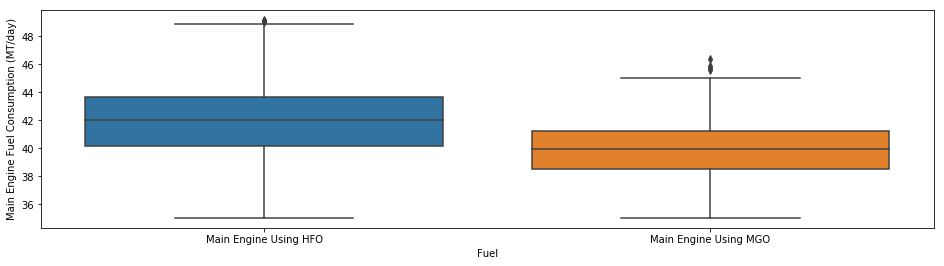

In [51]:
# Plot fuel consumption by fuel source
plt.figure('Fuel Source', figsize=(16,4))
sns.boxplot(x='Fuel', y=cols_main[1], data=df_fuel)

In [52]:
# Investigate multi-collinearity of shaft sensors (Power = Speed x Torque x unit conversion)
corr_shaft = df_mod[cols_shaft].corr()
corr_shaft

,Shaft Speed (RPM),Shaft Torque (kNm),Shaft Power (kW)
Shaft Speed (RPM),1.000000,0.653202,0.821253
Shaft Torque (kNm),0.653202,1.000000,0.968032
Shaft Power (kW),0.821253,0.968032,1.000000


In [53]:
# Investigate multi-collinearity of wind sensors
corr_wind = df_mod[cols_wind].corr()
corr_wind

,Weather Service Apparent Wind Speed (knots),Weather Service Apparent Wind Direction (degrees from bow),Weather Service True Wind Speed (knots),Weather Service True Wind Direction (degrees from north)
Weather Service Apparent Wind Speed (knots),1.000000,-0.043239,0.364930,0.095673
Weather Service Apparent Wind Direction (degrees from bow),-0.043239,1.000000,0.001263,0.100714
Weather Service True Wind Speed (knots),0.364930,0.001263,1.000000,0.072654
Weather Service True Wind Direction (degrees from north),0.095673,0.100714,0.072654,1.000000


In [54]:
# Investigate multi-collinearity of speed and heading sensors
corr_speed = df_mod[cols_speed].corr()
corr_speed

,Speed Over Ground (knots),Speed Through Water (knots),Heading (degrees),Rudder Angle (degrees)
Speed Over Ground (knots),1.000000,0.820221,-0.013601,-0.241684
Speed Through Water (knots),0.820221,1.000000,0.012183,-0.266597
Heading (degrees),-0.013601,0.012183,1.000000,-0.205813
Rudder Angle (degrees),-0.241684,-0.266597,-0.205813,1.000000


# Feature Engineering

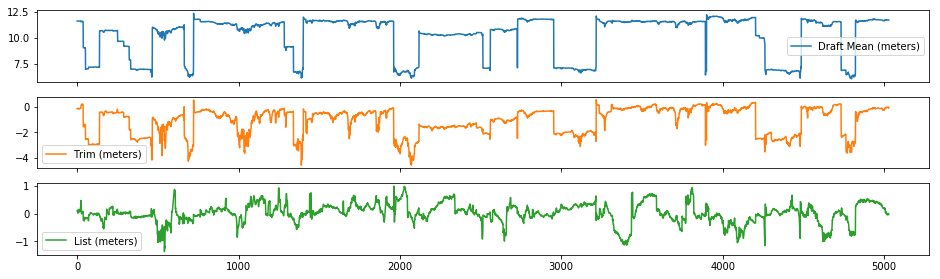

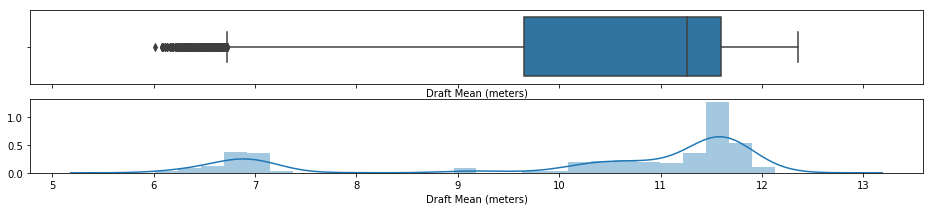

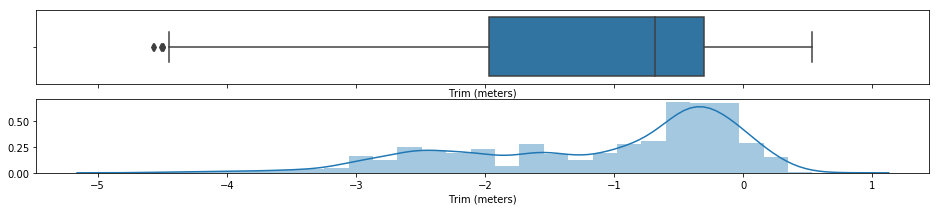

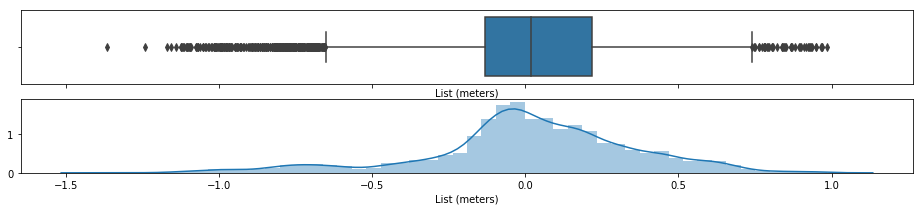

In [55]:
# Engineer features for mean draft, trim (aft heavy), list and positive list (possible nonlinear relationship)
df_mod['Draft Mean (meters)'] = df_mod[cols_draft].mean(axis=1)
df_mod['Trim (meters)']       = df_mod[cols_draft[0]] - df_mod[cols_draft[1]]
df_mod['List (meters)']       = df_mod[cols_draft[2]] - df_mod[cols_draft[3]]

# Plot time series
fig_draft_fe, axes_draft_fe = plt.subplots(3,1, figsize=(16,3*1.5), sharex=True)
df_mod[['Draft Mean (meters)',
        'Trim (meters)',
        'List (meters)']].plot(subplots=True, ax=axes_draft_fe)

# Draft mean
f, (ax_box, ax_hist) = plt.subplots(2, figsize=(16,2*1.5), sharex=True)
sns.boxplot( df_mod['Draft Mean (meters)'], ax=ax_box)
sns.distplot(df_mod['Draft Mean (meters)'], ax=ax_hist)

# Trim
f, (ax_box, ax_hist) = plt.subplots(2, figsize=(16,2*1.5), sharex=True)
sns.boxplot( df_mod['Trim (meters)'], ax=ax_box)
sns.distplot(df_mod['Trim (meters)'], ax=ax_hist)

# List
f, (ax_box, ax_hist) = plt.subplots(2, figsize=(16,2*1.5), sharex=True)
sns.boxplot( df_mod['List (meters)'], ax=ax_box)
sns.distplot(df_mod['List (meters)'], ax=ax_hist)

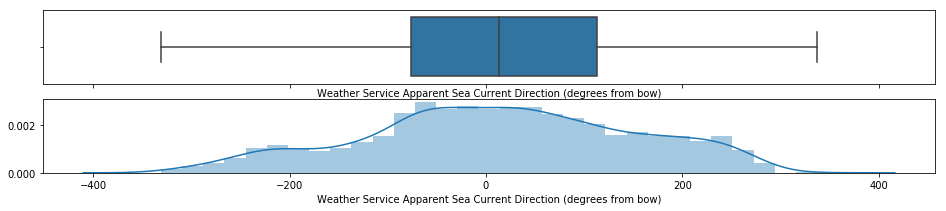

In [56]:
# Engineer features for apparent sea current direction and speed
col         = 'Weather Service Apparent Sea Current Direction (degrees from bow)'
df_mod[col] = df_mod[cols_speed[2]] - df_mod[cols_sea[1]]

# Apparent sea current direction
f, (ax_box, ax_hist) = plt.subplots(2, figsize=(16,2*1.5), sharex=True)
sns.boxplot( df_mod['Weather Service Apparent Sea Current Direction (degrees from bow)'], ax=ax_box)
sns.distplot(df_mod['Weather Service Apparent Sea Current Direction (degrees from bow)'], ax=ax_hist)

# Feature Selection

In [57]:
df_mod.columns

Index(['Time', 'Main Engine Fuel Consumption (MT/day)',
       'Main Engine Using HFO (bool)', 'Main Engine Using MGO (bool)',
       'Draft Forward (meters)', 'Draft Aft (meters)', 'Draft Mid-1 (meters)',
       'Draft Mid-2 (meters)', 'Shaft Speed (RPM)', 'Shaft Torque (kNm)',
       'Shaft Power (kW)', 'Speed Over Ground (knots)',
       'Speed Through Water (knots)', 'Heading (degrees)',
       'Rudder Angle (degrees)', 'Weather Service Apparent Wind Speed (knots)',
       'Weather Service Apparent Wind Direction (degrees from bow)',
       'Weather Service True Wind Speed (knots)',
       'Weather Service True Wind Direction (degrees from north)',
       'Weather Service Temperature (celsius)',
       'Weather Service Sea Current Direction (degrees from north)',
       'Weather Service Sea Current Speed (knots)', 'Water Depth (meters)',
       'Weather Service Wind Wave Significant Height (meters)',
       'Weather Service Wind Wave Period (seconds)',
       'Weather Service Wind 

In [58]:
df_feat = df_mod[['Main Engine Fuel Consumption (MT/day)',
#                  'Main Engine Using HFO (bool)',
                  'Main Engine Using MGO (bool)',
#                  'Draft Forward (meters)',
#                  'Draft Aft (meters)',
#                  'Draft Mid-1 (meters)',
#                  'Draft Mid-2 (meters)',
                  'Shaft Speed (RPM)',
                  'Shaft Torque (kNm)',
#                  'Shaft Power (kW)',
                  'Speed Over Ground (knots)',
                  'Speed Through Water (knots)',
#                  'Heading (degrees)',
#                  'Rudder Angle (degrees)',
                  'Weather Service Apparent Wind Speed (knots)',
#                  'Weather Service Apparent Wind Direction (degrees from bow)',
#                  'Weather Service True Wind Speed (knots)',
#                  'Weather Service True Wind Direction (degrees from north)',
                  'Weather Service Temperature (celsius)',
#                  'Weather Service Sea Current Direction (degrees from north)',
                  'Weather Service Sea Current Speed (knots)',
#                  'Water Depth (meters)',
#                  'Weather Service Wind Wave Significant Height (meters)',
#                  'Weather Service Wind Wave Period (seconds)',
#                  'Weather Service Wind Wave Direction (degrees from north)',
#                  'Fuel Gauge',
                  'Draft Mean (meters)',
                  'Trim (meters)',
                  'List (meters)']]
#                  'Weather Service Apparent Sea Current Direction (degrees from bow)']]

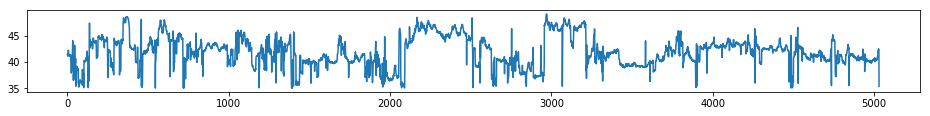

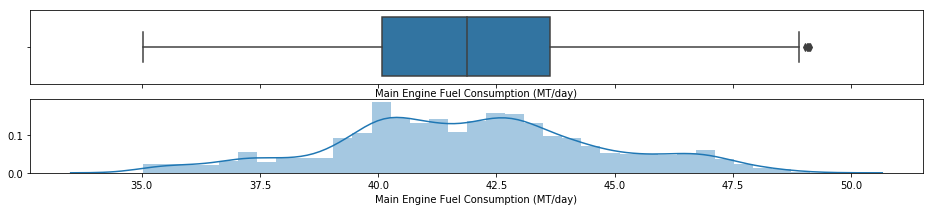

In [59]:
# Main engine fuel consumption
feat = 'Main Engine Fuel Consumption (MT/day)'

plt.subplots(figsize=(16,1.5))
df_feat[feat].plot()

f, (ax_box, ax_hist) = plt.subplots(2, figsize=(16,2*1.5), sharex=True)
sns.boxplot( df_feat[feat], ax=ax_box)
sns.distplot(df_feat[feat], ax=ax_hist)

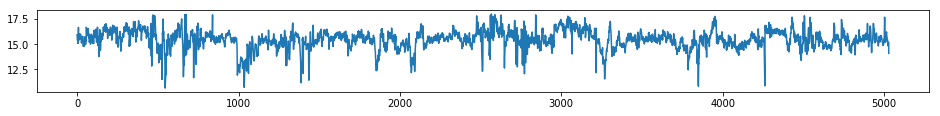

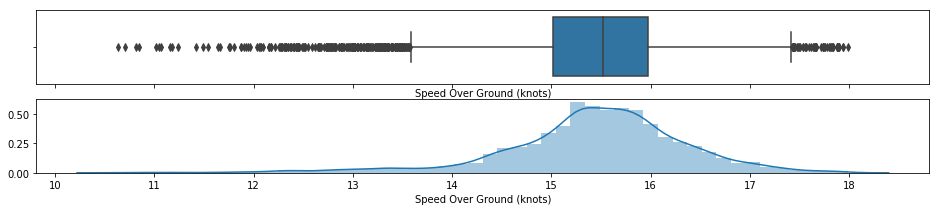

In [60]:
# Speed over ground
feat = 'Speed Over Ground (knots)'

plt.subplots(figsize=(16,1.5))
df_feat[feat].plot()

f, (ax_box, ax_hist) = plt.subplots(2, figsize=(16,2*1.5), sharex=True)
sns.boxplot( df_feat[feat], ax=ax_box)
sns.distplot(df_feat[feat], ax=ax_hist)

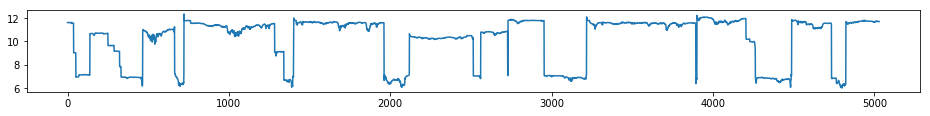

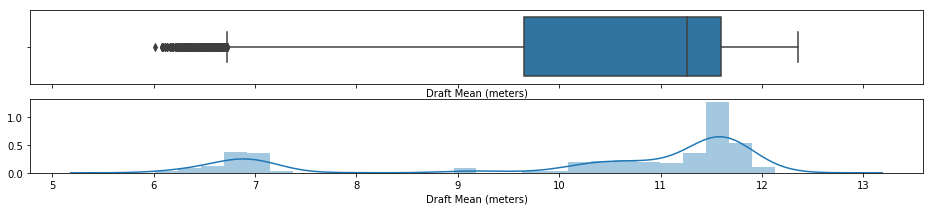

In [61]:
# Draft mean
feat = 'Draft Mean (meters)'

plt.subplots(figsize=(16,1.5))
df_feat[feat].plot()

f, (ax_box, ax_hist) = plt.subplots(2, figsize=(16,2*1.5), sharex=True)
sns.boxplot( df_feat[feat], ax=ax_box)
sns.distplot(df_feat[feat], ax=ax_hist)

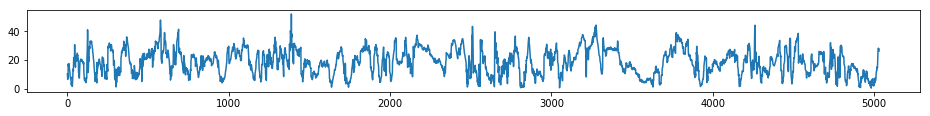

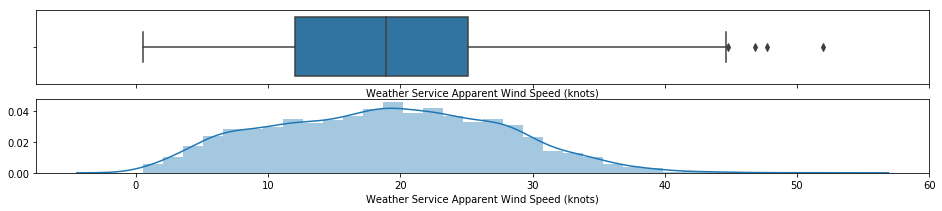

In [62]:
# Apparent wind speed
feat = 'Weather Service Apparent Wind Speed (knots)'

plt.subplots(figsize=(16,1.5))
df_feat[feat].plot()

f, (ax_box, ax_hist) = plt.subplots(2, figsize=(16,2*1.5), sharex=True)
sns.boxplot( df_feat[feat], ax=ax_box)
sns.distplot(df_feat[feat], ax=ax_hist)

# Regression Model

In [63]:
# Set target and feature variables
y = df_feat[     'Main Engine Fuel Consumption (MT/day)']
X = df_feat.drop('Main Engine Fuel Consumption (MT/day)',axis=1)

# Training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print(X_train.shape)
print(X_test.shape)

(4024, 11)
(1007, 11)


In [64]:
# Train regression model
reg = LinearRegression()
reg.fit(X_train, y_train)

features                = pd.DataFrame(X.columns.T, columns=['Feature'])
features['Coefficient'] = reg.coef_.T
features                = features.append({'Feature': 'Intercept','Coefficient': reg.intercept_}, ignore_index=True)
features.sort_values(by='Coefficient',ascending=False)

,Feature,Coefficient
1,Shaft Speed (RPM),0.411545
0,Main Engine Using MGO (bool),0.159597
4,Speed Through Water (knots),0.102803
2,Shaft Torque (kNm),0.039936
8,Draft Mean (meters),0.027798
5,Weather Service Apparent Wind Speed (knots),0.007470
3,Speed Over Ground (knots),-0.001678
6,Weather Service Temperature (celsius),-0.023128
10,List (meters),-0.050375
7,Weather Service Sea Current Speed (knots),-0.073561


R-squared score:         0.984
Root mean squared error: 0.356


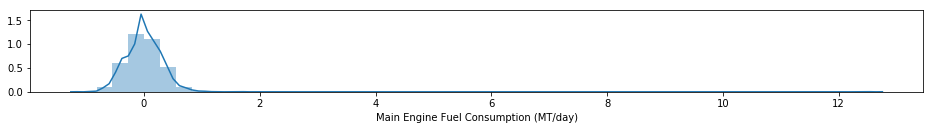

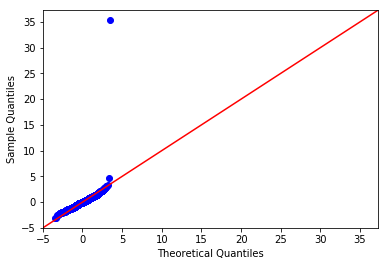

In [65]:
# Predictions of training set
y_train_pred = reg.predict(X_train)
print('R-squared score:         %.3f' % r2_score(y_train,  y_train_pred))
print("Root mean squared error: %.3f" % np.sqrt(mean_squared_error(y_train,  y_train_pred)))

# Residuals
resid_train  = y_train - y_train_pred

plt.subplots(figsize=(16,1.5))
sns.distplot(resid_train)

fig          = sm.graphics.qqplot(resid_train, dist=stats.norm, line='45', fit=True)
fig.show()

R-squared score:         0.988
Root mean squared error: 0.305


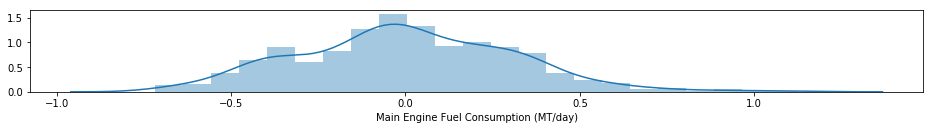

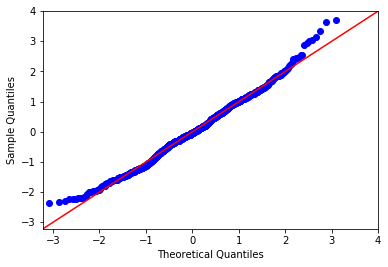

In [66]:
# Predictions of test set
y_test_pred = reg.predict(X_test)
print('R-squared score:         %.3f' % r2_score(y_test,  y_test_pred))
print("Root mean squared error: %.3f" % np.sqrt(mean_squared_error(y_test,  y_test_pred)))

# Residuals
resid_test  = y_test - y_test_pred

plt.subplots(figsize=(16,1.5))
sns.distplot(resid_test)

fig         = sm.graphics.qqplot(resid_test, dist=stats.norm, line='45', fit=True)
fig.show()

# Speed Scores

# Sensor Drift